# Étape 0 — Contexte et objectif du projet

* Vous utiliserez des données météo historiques fournies par Historical Weather API (Open-Meteo).
Cette API repose sur des ensembles de données de réanalyse des observations provenant de
différentes sources (stations météorologiques, radars, satellites, etc.) et, grâce à des modèles
mathématiques, fournit des informations météorologiques historiques détaillées, y compris pour des
zones sans station météorologique à proximité.

Vous devez récupérer une série temporelle des températures à 2m du sol (« Temperature (2 m) »)
pour une ville de votre choix, en utilisant ses coordonnées géographiques (latitude, longitude).

* Objectif
L’objectif est de développer un modèle de prédiction capable d’estimer la température de la ville
sélectionnée pour une journée donnée, avec un pas de temps de 3h (00h, 03h, 06h, …, 21h).

# Étape 1 : Imports (data, metrics, modèles)


In [17]:

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

# Open-Meteo API
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Time series models & tests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsaplots


# Étape 2 : Acquisition des données météo (API Open-Meteo)

In [ ]:
OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"
DEFAULT_COORDS = {"latitude": 42.7022, "longitude": 9.4512}  # Bastia
DEFAULT_START = "2023-01-01"
DEFAULT_END   = "2024-12-31"

# Setup a session for API calls with caching and retries
cache_session = requests_cache.CachedSession('.cache', expire_after_days=0.5)
request = retry(cache_session, retries=5, backoff_factor=0.2)

def fetch_open_meteo(latitude: float, longitude: float, start_date: str, end_date: str) -> pd.DataFrame:
    """Télécharge les températures 2m et l'humidité relative horaires, index datetime, interpolation linéaire si trous."""
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m"],
        "timezone": "UTC"
    }
    resp = request.get(OPEN_METEO_URL, params=params, timeout=30)
    resp.raise_for_status()
    payload = resp.json()
    hourly = payload.get("hourly", {})
    df = pd.DataFrame(hourly)
    df.rename(columns={"relative_humidity_2m": "humidity"}, inplace=True)
    df["time"] = pd.to_datetime(df["time"], utc=True)
    df.set_index("time", inplace=True)
    # Vérification et interpolation linéaire si valeurs manquantes
    if df.isna().any().any():
        df = df.interpolate(method="time", limit_direction="both")
    return df

# Vérification et traitement des valeurs manquantes

raw_hourly = fetch_open_meteo(**DEFAULT_COORDS, start_date=DEFAULT_START, end_date=DEFAULT_END)
raw_hourly.head()

,temperature_2m,humidity
time,,
2023-01-01 00:00:00+00:00,13.2,98
2023-01-01 01:00:00+00:00,12.7,99
2023-01-01 02:00:00+00:00,12.6,100
2023-01-01 03:00:00+00:00,12.5,100
2023-01-01 04:00:00+00:00,11.2,100


Les données météorologiques ont été récupérées via l’API Open-Meteo pour la ville de Bastia (latitude 42.7022, longitude 9.4512).
La période d’étude couvre dix années, de janvier 2015 à décembre 2024, afin de capturer les variations saisonnières et interannuelles.
Les températures à 2 m et l’humidité relative ont été extraites à une fréquence horaire, indexées en UTC et les éventuelles valeurs manquantes ont été corrigées par **interpolation linéaire**.



# 3 — TRANSFORMATION DE LA SÉRIE TEMPORELLE
 - Agrégation horaire → pas de 3 heures



In [19]:
# Moyenne des valeurs horaires sur des fenêtres de 3 heures
daily_data = raw_hourly.resample("3H").mean()

daily_data.head()

/tmp/ipython-input-1280324172.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_data = raw_hourly.resample("3H").mean()


,temperature_2m,humidity
time,,
2023-01-01 00:00:00+00:00,12.833333,99.000000
2023-01-01 03:00:00+00:00,11.333333,100.000000
2023-01-01 06:00:00+00:00,11.300000,98.333333
2023-01-01 09:00:00+00:00,14.100000,91.000000
2023-01-01 12:00:00+00:00,14.900000,86.666667


# 4 — ANALYSE EXPLORATOIRE (EDA)
- Visualisation globale de la série





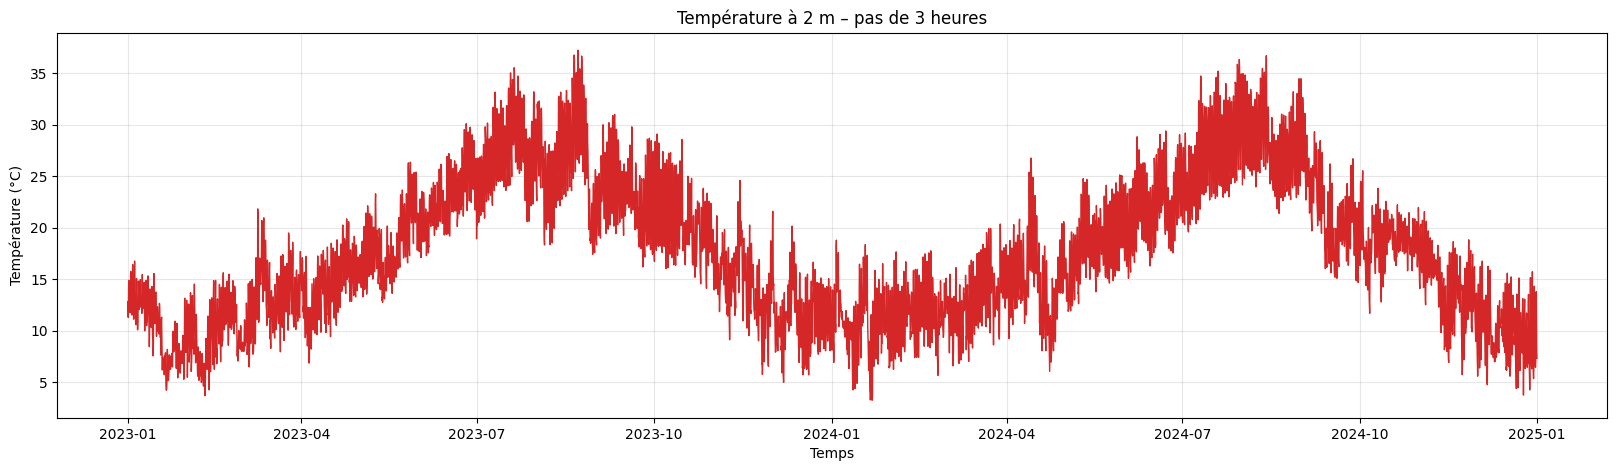

In [20]:
# Extraction de la température à 2 m comme série temporelle principale
ts_data = daily_data["temperature_2m"]

ts_data.head()

plt.figure(figsize=(20,5))
plt.plot(ts_data, color="tab:red", linewidth=1)
plt.title("Température à 2 m – pas de 3 heures")
plt.xlabel("Temps")
plt.ylabel("Température (°C)")
plt.grid(alpha=0.3)
plt.show()

# Étape 5 — Tests de stationnarité ADF, KPSS

In [21]:
from statsmodels.tsa.stattools import kpss, adfuller

adf_result = adfuller(ts_data)

# ADF
adf_stat, adf_pvalue, _, _, adf_crit, _ = adfuller(ts_data)

# KPSS
kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts_data, regression="c", nlags="auto")

# Tableau récapitulatif
stationarity_tests = pd.DataFrame({
    "Test": ["ADF", "KPSS"],
    "Statistic": [adf_stat, kpss_stat],
    "p-value": [adf_pvalue, kpss_pvalue]
})

stationarity_tests


/tmp/ipython-input-1312919334.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pvalue, _, kpss_crit = kpss(ts_data, regression="c", nlags="auto")


,Test,Statistic,p-value
0,ADF,-2.279723,0.178591
1,KPSS,0.957128,0.010000


Les tests **ADF** et **KPSS** ont été appliqués à la série de température agrégée. Les deux tests indiquent une stationnarité statistique de la série. Toutefois, la présence d’une saisonnalité marquée justifie l’utilisation de modèles saisonniers de type SARIMA.

# 6 — DÉCOUPAGE TRAIN / VALIDATION / TEST

In [22]:
len_train = int(len(ts_data) * 0.65)
len_val   = int(len(ts_data) * 0.20)

ts_train = ts_data[:len_train]
ts_val   = ts_data[len_train:len_train + len_val]
ts_test  = ts_data[len_train + len_val:]

ts_train.head(), ts_val.head(), ts_test.head()


(time
 2023-01-01 00:00:00+00:00    12.833333
 2023-01-01 03:00:00+00:00    11.333333
 2023-01-01 06:00:00+00:00    11.300000
 2023-01-01 09:00:00+00:00    14.100000
 2023-01-01 12:00:00+00:00    14.900000
 Freq: 3h, Name: temperature_2m, dtype: float64,
 time
 2024-04-20 03:00:00+00:00    10.866667
 2024-04-20 06:00:00+00:00    15.800000
 2024-04-20 09:00:00+00:00    17.166667
 2024-04-20 12:00:00+00:00    18.233333
 2024-04-20 15:00:00+00:00    17.233333
 Freq: 3h, Name: temperature_2m, dtype: float64,
 time
 2024-09-13 06:00:00+00:00    18.733333
 2024-09-13 09:00:00+00:00    19.500000
 2024-09-13 12:00:00+00:00    19.966667
 2024-09-13 15:00:00+00:00    19.200000
 2024-09-13 18:00:00+00:00    16.833333
 Freq: 3h, Name: temperature_2m, dtype: float64)

Les jeux d’entraînement et de validation représentent respectivement 65 % et 20 % des données. Le jeu de test correspond aux 15 % restants, utilisés uniquement pour l’évaluation finale des modèles.


# 7 — ANALYSE DES AUTOCORRÉLATIONS (ACF)

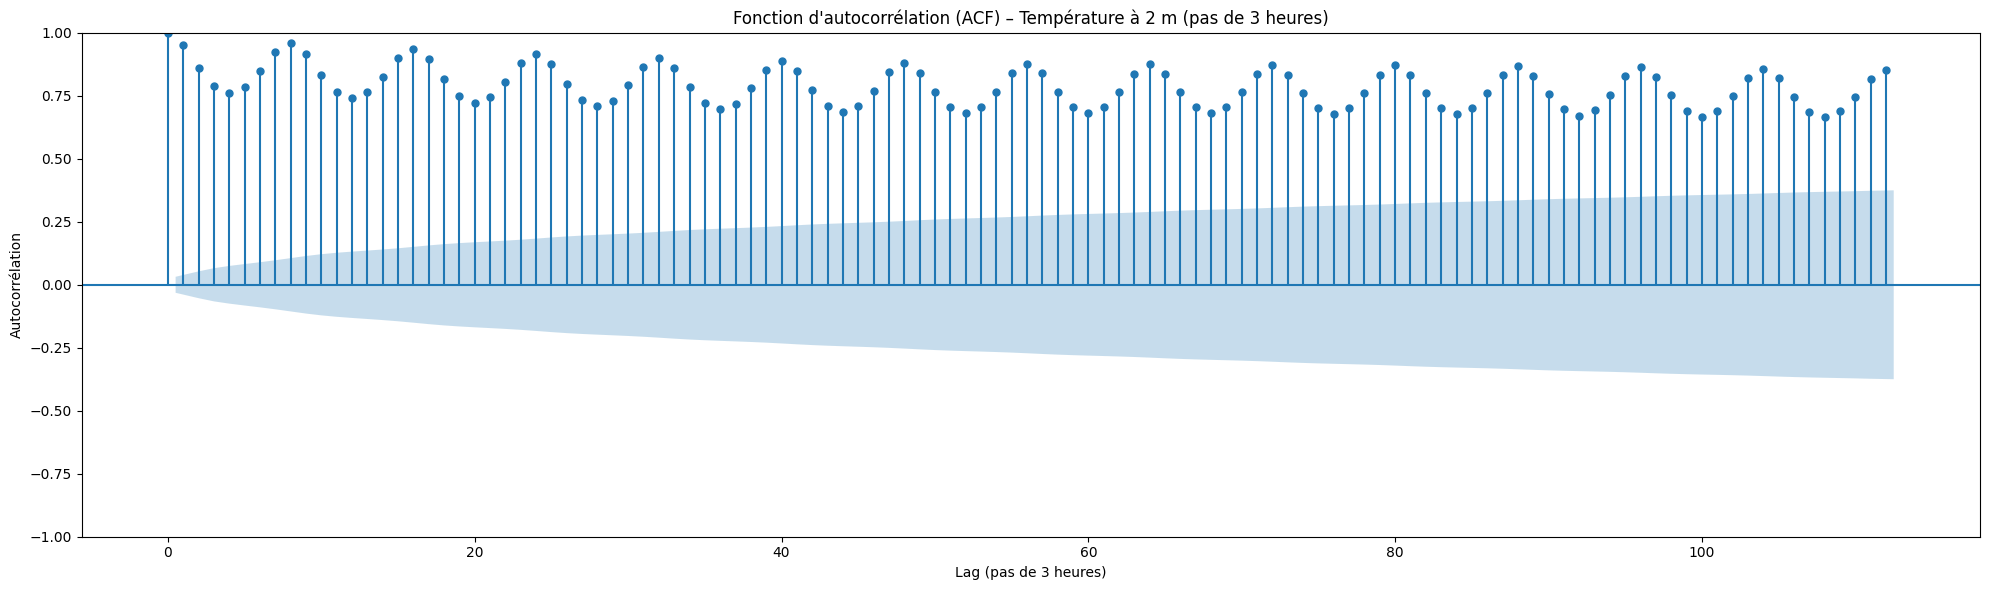

In [23]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

tsaplots.plot_acf(ts_train, lags=112, ax=ax)

ax.set_title("Fonction d'autocorrélation (ACF) – Température à 2 m (pas de 3 heures)")
ax.set_xlabel("Lag (pas de 3 heures)")
ax.set_ylabel("Autocorrélation")

plt.tight_layout()
plt.show()

L’ACF montre une forte autocorrélation persistante et une structure périodique, indiquant une dépendance temporelle et une saisonnalité marquée de la série.

# 8 — MODÉLISATION STATISTIQUE : ARIMA

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Paramètres ARIMA
p = 4
d = 1
q = 5

model = SARIMAX(ts_train, order=(p, d, q))
res = model.fit(disp=False)

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         temperature_2m   No. Observations:                 3801
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -5796.149
Date:                Fri, 19 Dec 2025   AIC                          11612.298
Time:                        08:28:35   BIC                          11674.726
Sample:                    01-01-2023   HQIC                         11634.485
                         - 04-20-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4137      0.003    414.863      0.000       1.407       1.420
ar.L2         -1.9810      0.006   -345.469      0.000      -1.992      -1.970
ar.L3          1.3883      0.006    241.859      0.000       1.377       1.400
ar.L4         -0.9818      0.003   -304.893      0.000      -0.988      -0.976
ma.L1         -1.5708      0.016    -99.480      0.000      -1.602      -1.540
ma.L2          2.0760      0.025     82.432      0.000       2.027       2.125
ma.L3         -1.6478      0.032    -52.055      0.000      -1.710      -1.586
ma.L4          1.0939      0.024     45.010      0.000       1.046       1.142
ma.L5         -0.1891      0.015    -12.277      0.000      -0.219      -0.159
sigma2         1.2601      0.026     49.139      0.000       1.210       1.310
===================================================================================
Ljung-Box (L1) (Q):                   2.99   Jarque-Bera (JB):               197.71
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)


def evaluate_arima(order, ts_train, ts_val):
    try:
        model = SARIMAX(
            ts_train,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        # Prédiction sur la validation
        pred = res.predict(
            start=ts_val.index[0],
            end=ts_val.index[-1]
        )

        rmse = sqrt(mean_squared_error(ts_val, pred))
        return order, res.aic, rmse

    except Exception:
        return order, np.inf, np.inf






# 9 — GRID SEARCH ARIMA

In [26]:
from itertools import product
from tqdm import tqdm

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

orders = list(product(p_values, d_values, q_values))

results = []

for order in tqdm(orders, desc="Grid search ARIMA"):
    results.append(
        evaluate_arima(order, ts_train, ts_val)
    )

# Tri par RMSE (performance prédictive)
results_sorted = sorted(results, key=lambda x: x[2])

results_sorted[:10]



Grid search ARIMA: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]


[((1, 1, 2), np.float64(14675.499559832855), 10.885176172383037),
 ((2, 0, 2), np.float64(14682.61566838898), 11.820569446070998),
 ((2, 1, 2), np.float64(13622.801161788148), 12.165703607468284),
 ((2, 1, 1), np.float64(13947.125033023152), 12.247975046489197),
 ((0, 1, 2), np.float64(15470.271725608696), 12.442837084411668),
 ((2, 1, 0), np.float64(15186.791677752954), 14.380411588545837),
 ((0, 1, 0), np.float64(16497.853816774288), 15.259504603779906),
 ((0, 1, 1), np.float64(15456.331469187018), 15.513248515267406),
 ((1, 1, 1), np.float64(15458.329444107774), 15.513728284057466),
 ((1, 1, 0), np.float64(15856.77317394099), 15.762722243379818)]

MODÉLISATION STATISTIQUE : SARIMA

In [27]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# (optionnel) pour éviter le spam de warnings pendant la recherche
warnings.simplefilter("ignore", ConvergenceWarning)

def evaluate_sarima(order, seasonal_order, ts_train, ts_val):
    try:
        model = SARIMAX(
            ts_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        pred = res.predict(start=ts_val.index[0], end=ts_val.index[-1])
        rmse = sqrt(mean_squared_error(ts_val, pred))

        return order, seasonal_order, res.aic, rmse
    except Exception:
        return order, seasonal_order, np.inf, np.inf





 # 11 - GRID SEARCH SARIMA

In [28]:
from itertools import product
from tqdm import tqdm

s = 8  # saisonnalité journalière (pas de 3h)

p_vals = [0, 1, 2]
d_vals = [0, 1]
q_vals = [0, 1, 2]

P_vals = [0, 1]
D_vals = [0, 1]
Q_vals = [0, 1]

orders = list(product(p_vals, d_vals, q_vals))
seasonal_orders = [(P, D, Q, s) for P, D, Q in product(P_vals, D_vals, Q_vals)]

results = []

total_iter = len(orders) * len(seasonal_orders)

for order, seasonal_order in tqdm(
    product(orders, seasonal_orders),
    total=total_iter,
    desc="Grid search SARIMA"
):
    results.append(
        evaluate_sarima(order, seasonal_order, ts_train, ts_val)
    )

# Tri par RMSE validation
results_sorted = sorted(results, key=lambda x: x[3])

results_sorted[:10]



Grid search SARIMA: 100%|██████████| 144/144 [04:50<00:00,  2.02s/it]


[((1, 1, 1), (1, 1, 1, 8), np.float64(10807.693925135472), 5.271235604333571),
 ((1, 1, 1), (0, 1, 1, 8), np.float64(10855.521187183007), 6.239462596714714),
 ((0, 1, 2), (0, 1, 0, 8), np.float64(12710.401585000174), 7.367763009036903),
 ((1, 0, 1), (1, 1, 1, 8), np.float64(10728.99700736456), 9.57315051035102),
 ((2, 0, 0), (1, 1, 1, 8), np.float64(10754.56415884154), 9.58407198599802),
 ((2, 0, 1), (1, 1, 1, 8), np.float64(10708.18158793401), 9.604072443705364),
 ((0, 0, 2), (1, 1, 1, 8), np.float64(11664.363534656208), 9.625019567580212),
 ((1, 0, 0), (1, 1, 1, 8), np.float64(10819.955307262715), 9.671191167486553),
 ((1, 0, 1), (0, 1, 1, 8), np.float64(10757.113509825427), 9.680593816862386),
 ((2, 0, 0), (0, 1, 1, 8), np.float64(10786.75282260641), 9.701603502803264)]

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

best_order = (2, 0, 1)
best_seasonal = (1, 0, 1, 8)

ts_train_val = pd.concat([ts_train, ts_val])

final_model = SARIMAX(
    ts_train_val,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


In [30]:
pred_test = final_model.predict(
    start=ts_test.index[0],
    end=ts_test.index[-1]
)

rmse_test = sqrt(mean_squared_error(ts_test, pred_test))
rmse_test


8.32262607305021

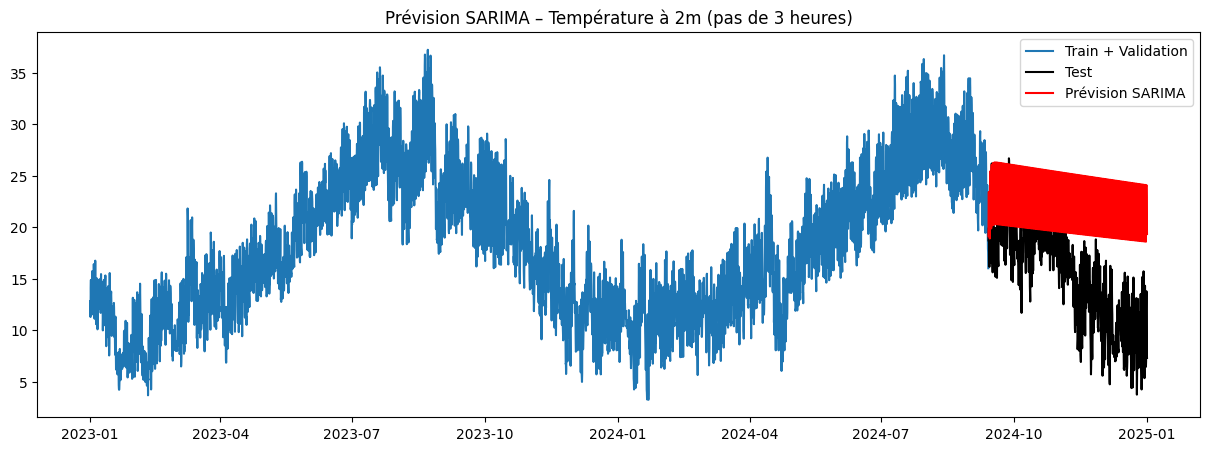

In [31]:
plt.figure(figsize=(15,5))
plt.plot(ts_train_val.index, ts_train_val, label="Train + Validation")
plt.plot(ts_test.index, ts_test, label="Test", color="black")
plt.plot(pred_test.index, pred_test, label="Prévision SARIMA", color="red")
plt.legend()
plt.title("Prévision SARIMA – Température à 2m (pas de 3 heures)")
plt.show()


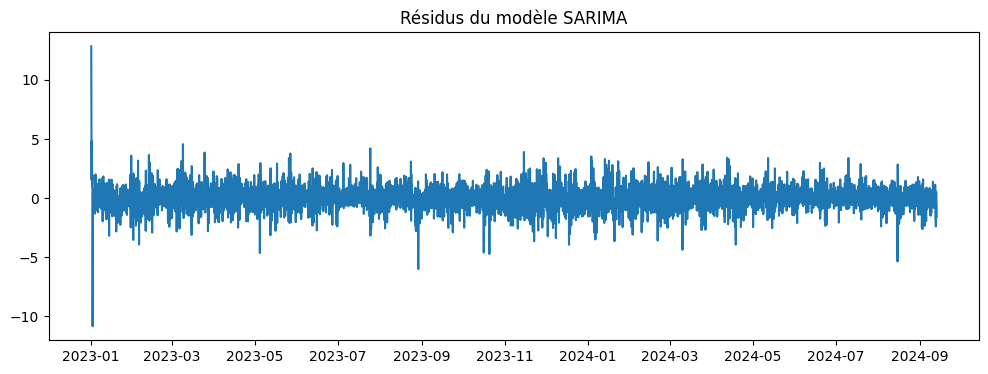

In [32]:
residuals = final_model.resid

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Résidus du modèle SARIMA")
plt.show()


In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

# ======================================================
# 1) SÉRIE CIBLE (température)
# ======================================================
ts_data = daily_data["temperature_2m"]

# SARIMAX (VARIABLE EXOGÈNE : HUMIDITÉ)

In [34]:
# ======================================================
# 2) VARIABLE EXOGÈNE (humidité)
# ======================================================
exog_data = daily_data["humidity"]

# ======================================================
# 3) ALIGNEMENT TRAIN / VAL / TEST
# ======================================================
exog_train = exog_data.loc[ts_train.index]
exog_val   = exog_data.loc[ts_val.index]
exog_test  = exog_data.loc[ts_test.index]

ts_train_val = pd.concat([ts_train, ts_val])
exog_train_val = pd.concat([exog_train, exog_val])

In [35]:
# ======================================================
# 4) PARAMÈTRES RETENUS (SARIMA OPTIMAL)
# ======================================================
order = (2, 0, 1)
seasonal_order = (1, 0, 1, 8)

# ======================================================
# 5) ENTRAÎNEMENT SARIMAX
# ======================================================
sarimax_model = SARIMAX(
    ts_train_val,
    exog=exog_train_val,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    temperature_2m   No. Observations:                 4970
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 8)   Log Likelihood               -5737.175
Date:                           Fri, 19 Dec 2025   AIC                          11488.350
Time:                                   08:34:00   BIC                          11533.914
Sample:                               01-01-2023   HQIC                         11504.326
                                    - 09-13-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.0840      0.001    -66.822      0.000      -0.086      -0.082
ar.L1          0.7420      0.054     13.713      0.000       0.636       0.848
ar.L2          0.1499      0.051      2.916      0.004       0.049       0.251
ma.L1          0.4009      0.052      7.746      0.000       0.299       0.502
ar.S.L8        0.9995      0.001   1813.724      0.000       0.998       1.001
ma.S.L8       -0.8696      0.006   -138.296      0.000      -0.882      -0.857
sigma2         0.5905      0.009     67.813      0.000       0.573       0.608
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               833.91
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.20
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# ======================================================
# 6) PRÉDICTION SUR LE JEU TEST
# ======================================================
pred_test = sarimax_model.predict(
    start=ts_test.index[0],
    end=ts_test.index[-1],
    exog=exog_test
)

In [37]:

# ======================================================
# 7) ÉVALUATION
# ======================================================
rmse_test = sqrt(mean_squared_error(ts_test, pred_test))
pd.DataFrame({
    "Modèle": ["SARIMAX"],
    "RMSE_test": [rmse_test]
})

,Modèle,RMSE_test
0,SARIMAX,8.352181


# Étape 16 — Analyse des résidus et performances finales

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA (sans saisonnalité, sans exogène)
arima_order = (2, 0, 1)

arima_model = SARIMAX(
    ts_train_val,
    order=arima_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

arima_pred_test = arima_model.predict(
    start=ts_test.index[0],
    end=ts_test.index[-1]
)

arima_rmse = sqrt(mean_squared_error(ts_test, arima_pred_test))
arima_mae  = mean_absolute_error(ts_test, arima_pred_test)

arima_rmse, arima_mae


(14.232002273314484, 13.511088323312546)

In [39]:
# SARIMA (avec saisonnalité journalière)
sarima_order = (2, 0, 1)
sarima_seasonal = (1, 0, 1, 8)

sarima_model = SARIMAX(
    ts_train_val,
    order=sarima_order,
    seasonal_order=sarima_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_pred_test = sarima_model.predict(
    start=ts_test.index[0],
    end=ts_test.index[-1]
)

sarima_rmse = sqrt(mean_squared_error(ts_test, sarima_pred_test))
sarima_mae  = mean_absolute_error(ts_test, sarima_pred_test)

sarima_rmse, sarima_mae


(8.32262607305021, 7.305687694384187)

In [40]:
# SARIMAX (avec variable exogène : humidity)
sarimax_order = (2, 0, 1)
sarimax_seasonal = (1, 0, 1, 8)

sarimax_model = SARIMAX(
    ts_train_val,
    exog=exog_train_val,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarimax_pred_test = sarimax_model.predict(
    start=ts_test.index[0],
    end=ts_test.index[-1],
    exog=exog_test
)

sarimax_rmse = sqrt(mean_squared_error(ts_test, sarimax_pred_test))
sarimax_mae  = mean_absolute_error(ts_test, sarimax_pred_test)

sarimax_rmse, sarimax_mae


(8.352180643395092, 7.088941293338189)

# Étape 12 — Évaluation finale des modèles statistiques
- Comparaison ARIMA / SARIMA / SARIMAX sur le jeu test

In [41]:
results_stats = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "SARIMAX"],
    "RMSE_test": [arima_rmse, sarima_rmse, sarimax_rmse],
    "MAE_test":  [arima_mae, sarima_mae, sarimax_mae]
})

results_stats


,Model,RMSE_test,MAE_test
0,ARIMA,14.232002,13.511088
1,SARIMA,8.322626,7.305688
2,SARIMAX,8.352181,7.088941


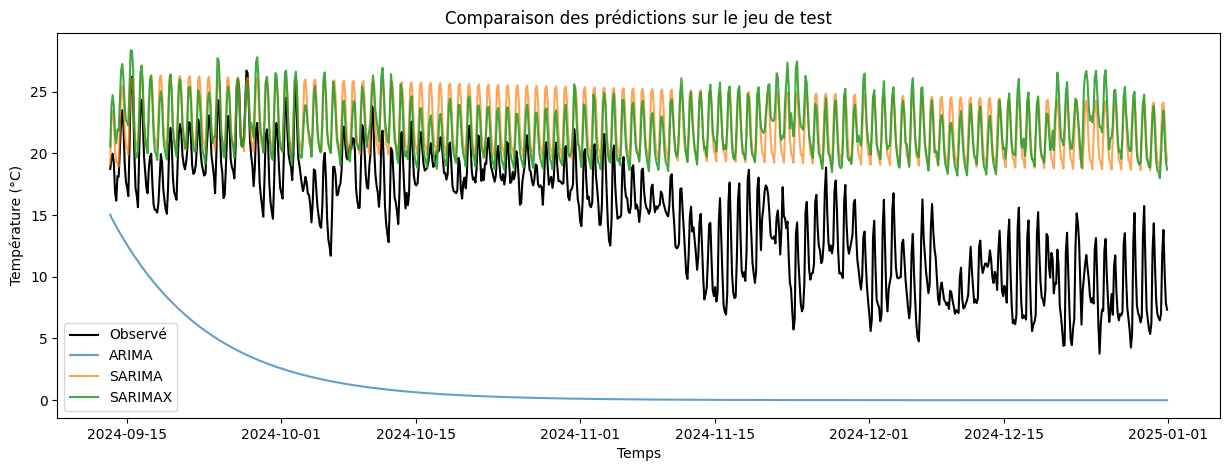

In [42]:
plt.figure(figsize=(15,5))
plt.plot(ts_test.index, ts_test.values, label="Observé", color="black")
plt.plot(arima_pred_test.index, arima_pred_test, label="ARIMA", alpha=0.7)
plt.plot(sarima_pred_test.index, sarima_pred_test, label="SARIMA", alpha=0.7)
plt.plot(sarimax_pred_test.index, sarimax_pred_test, label="SARIMAX", alpha=0.9)

plt.title("Comparaison des prédictions sur le jeu de test")
plt.xlabel("Temps")
plt.ylabel("Température (°C)")
plt.legend()
plt.show()


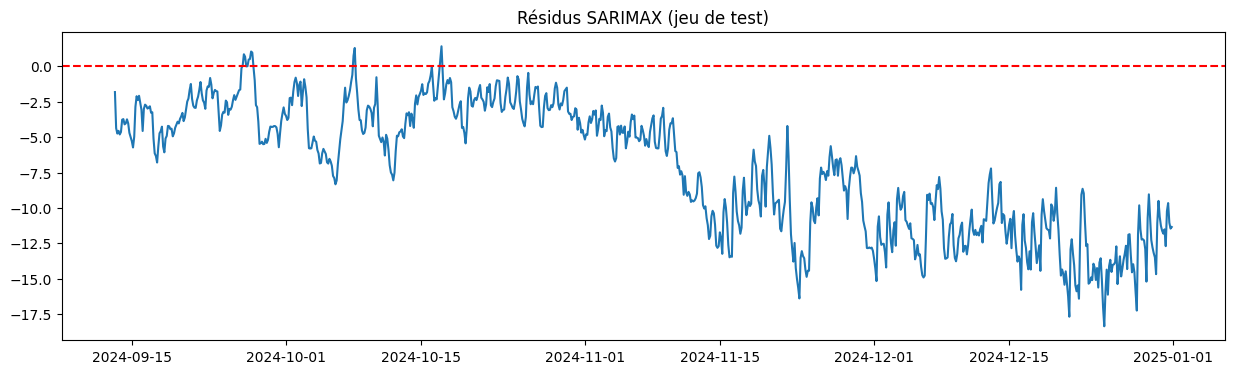

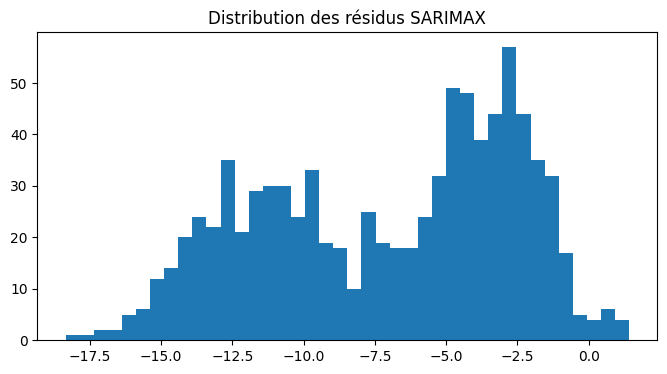

In [43]:
# Résidus SARIMAX
residuals_sarimax = ts_test - sarimax_pred_test

# Résidus dans le temps
plt.figure(figsize=(15,4))
plt.plot(residuals_sarimax)
plt.title("Résidus SARIMAX (jeu de test)")
plt.axhline(0, color="red", linestyle="--")
plt.show()

# Histogramme des résidus
plt.figure(figsize=(8,4))
plt.hist(residuals_sarimax, bins=40)
plt.title("Distribution des résidus SARIMAX")
plt.show()


# 13- Méthodes de régression (Machine Learning)

In [44]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Copie de sécurité
df = daily_data.copy()

# Variable cible
df["y"] = df["temperature_2m"]

# Lags température (1 journée = 8 pas de 3h)
for lag in range(1, 9):
    df[f"temp_lag_{lag}"] = df["temperature_2m"].shift(lag)

# Lags humidité (variable exogène)
for lag in range(1, 9):
    df[f"hum_lag_{lag}"] = df["humidity"].shift(lag)

# Variables calendaires
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

# Suppression des lignes avec NaN (créées par les lags)
df_ml = df.dropna().copy()

df_ml.head()


,temperature_2m,humidity,y,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,temp_lag_6,temp_lag_7,...,hum_lag_2,hum_lag_3,hum_lag_4,hum_lag_5,hum_lag_6,hum_lag_7,hum_lag_8,hour,dayofweek,month
time,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00+00:00,12.266667,98.666667,12.266667,12.433333,12.666667,12.966667,14.900000,14.100000,11.300000,11.333333,...,97.333333,97.333333,86.666667,91.000000,98.333333,100.000000,99.000000,0,0,1
2023-01-02 03:00:00+00:00,11.766667,99.666667,11.766667,12.266667,12.433333,12.666667,12.966667,14.900000,14.100000,11.300000,...,98.000000,97.333333,97.333333,86.666667,91.000000,98.333333,100.000000,3,0,1
2023-01-02 06:00:00+00:00,11.833333,99.000000,11.833333,11.766667,12.266667,12.433333,12.666667,12.966667,14.900000,14.100000,...,98.666667,98.000000,97.333333,97.333333,86.666667,91.000000,98.333333,6,0,1
2023-01-02 09:00:00+00:00,14.266667,89.666667,14.266667,11.833333,11.766667,12.266667,12.433333,12.666667,12.966667,14.900000,...,99.666667,98.666667,98.000000,97.333333,97.333333,86.666667,91.000000,9,0,1
2023-01-02 12:00:00+00:00,15.766667,82.333333,15.766667,14.266667,11.833333,11.766667,12.266667,12.433333,12.666667,12.966667,...,99.000000,99.666667,98.666667,98.000000,97.333333,97.333333,86.666667,12,0,1


In [45]:
feature_cols = (
    [f"temp_lag_{lag}" for lag in range(1, 9)] +
    [f"hum_lag_{lag}" for lag in range(1, 9)] +
    ["hour", "dayofweek", "month"]
)

X = df_ml[feature_cols]
y = df_ml["y"]

X.head(), y.head()


(                           temp_lag_1  temp_lag_2  temp_lag_3  temp_lag_4  \
 time                                                                        
 2023-01-02 00:00:00+00:00   12.433333   12.666667   12.966667   14.900000   
 2023-01-02 03:00:00+00:00   12.266667   12.433333   12.666667   12.966667   
 2023-01-02 06:00:00+00:00   11.766667   12.266667   12.433333   12.666667   
 2023-01-02 09:00:00+00:00   11.833333   11.766667   12.266667   12.433333   
 2023-01-02 12:00:00+00:00   14.266667   11.833333   11.766667   12.266667   
 
                            temp_lag_5  temp_lag_6  temp_lag_7  temp_lag_8  \
 time                                                                        
 2023-01-02 00:00:00+00:00   14.100000   11.300000   11.333333   12.833333   
 2023-01-02 03:00:00+00:00   14.900000   14.100000   11.300000   11.333333   
 2023-01-02 06:00:00+00:00   12.966667   14.900000   14.100000   11.300000   
 2023-01-02 09:00:00+00:00   12.666667   12.966667   14.900000

In [46]:
n = len(df_ml)

n_train = int(n * 0.65)
n_val   = int(n * 0.20)

X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

X_val = X.iloc[n_train:n_train + n_val]
y_val = y.iloc[n_train:n_train + n_val]

X_test = X.iloc[n_train + n_val:]
y_test = y.iloc[n_train + n_val:]

len(X_train), len(X_val), len(X_test)


(3796, 1168, 876)

In [47]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [48]:
pred_val = rf.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, pred_val))
mae_val  = mean_absolute_error(y_val, pred_val)

pd.DataFrame({
    "Modèle": ["Random Forest"],
    "RMSE (validation)": [rmse_val],
    "MAE (validation)": [mae_val]
})


,Modèle,RMSE (validation),MAE (validation)
0,Random Forest,1.028835,0.780379


In [49]:
importances = pd.Series(
    rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

importances.head(10)



,0
temp_lag_8,0.526055
temp_lag_1,0.429923
temp_lag_7,0.008822
hour,0.006559
hum_lag_3,0.002751
temp_lag_2,0.002562
temp_lag_4,0.002351
hum_lag_2,0.002304
temp_lag_6,0.002186
temp_lag_5,0.002155


In [50]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Configurations de variables explicatives

config_features = {
    "C1_lags_temp": [f"temp_lag_{lag}" for lag in range(1, 9)],

    "C2_lags_temp_humidity": (
        [f"temp_lag_{lag}" for lag in range(1, 9)] +
        [f"hum_lag_{lag}" for lag in range(1, 9)]
    ),

    "C3_lags_temp_humidity_calendar": (
        [f"temp_lag_{lag}" for lag in range(1, 9)] +
        [f"hum_lag_{lag}" for lag in range(1, 9)] +
        ["hour", "dayofweek", "month"]
    )
}



In [51]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae  = mean_absolute_error(y_test, preds)
    return rmse, mae


In [52]:
ridge_results = []

for name, features in config_features.items():
    X_train_cfg = X_train[features]
    X_test_cfg  = X_test[features]

    ridge = Ridge(alpha=1.0)
    rmse, mae = evaluate_model(
        ridge,
        X_train_cfg, y_train,
        X_test_cfg, y_test
    )

    ridge_results.append({
        "Model": "Ridge",
        "Config": name,
        "RMSE_test": rmse,
        "MAE_test": mae
    })

ridge_results


[{'Model': 'Ridge',
  'Config': 'C1_lags_temp',
  'RMSE_test': 1.1737476943662297,
  'MAE_test': 0.9045825727339898},
 {'Model': 'Ridge',
  'Config': 'C2_lags_temp_humidity',
  'RMSE_test': 1.1330434452125246,
  'MAE_test': 0.8633059561075862},
 {'Model': 'Ridge',
  'Config': 'C3_lags_temp_humidity_calendar',
  'RMSE_test': 1.1320161367616157,
  'MAE_test': 0.8643990351131217}]

In [53]:
ridge_results_df = pd.DataFrame(ridge_results)
ridge_results_df


,Model,Config,RMSE_test,MAE_test
0,Ridge,C1_lags_temp,1.173748,0.904583
1,Ridge,C2_lags_temp_humidity,1.133043,0.863306
2,Ridge,C3_lags_temp_humidity_calendar,1.132016,0.864399


In [54]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Prédictions RF sur le jeu test
rf_pred_test = rf.predict(X_test)

# Métriques RF
rmse_test = sqrt(mean_squared_error(y_test, rf_pred_test))
mae_test  = mean_absolute_error(y_test, rf_pred_test)

rmse_test, mae_test


(1.1144252980593274, 0.841146499238965)

In [55]:
final_ml_results = pd.concat([
    ridge_results_df,
    pd.DataFrame([{
        "Model": "RandomForest",
        "Config": "C3_lags_temp_humidity_calendar",
        "RMSE_test": rmse_test,
        "MAE_test": mae_test
    }])
])

final_ml_results


,Model,Config,RMSE_test,MAE_test
0,Ridge,C1_lags_temp,1.173748,0.904583
1,Ridge,C2_lags_temp_humidity,1.133043,0.863306
2,Ridge,C3_lags_temp_humidity_calendar,1.132016,0.864399
0,RandomForest,C3_lags_temp_humidity_calendar,1.114425,0.841146


# **Analyse des résidus du meilleur modèle Machine Learning**

In [56]:
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


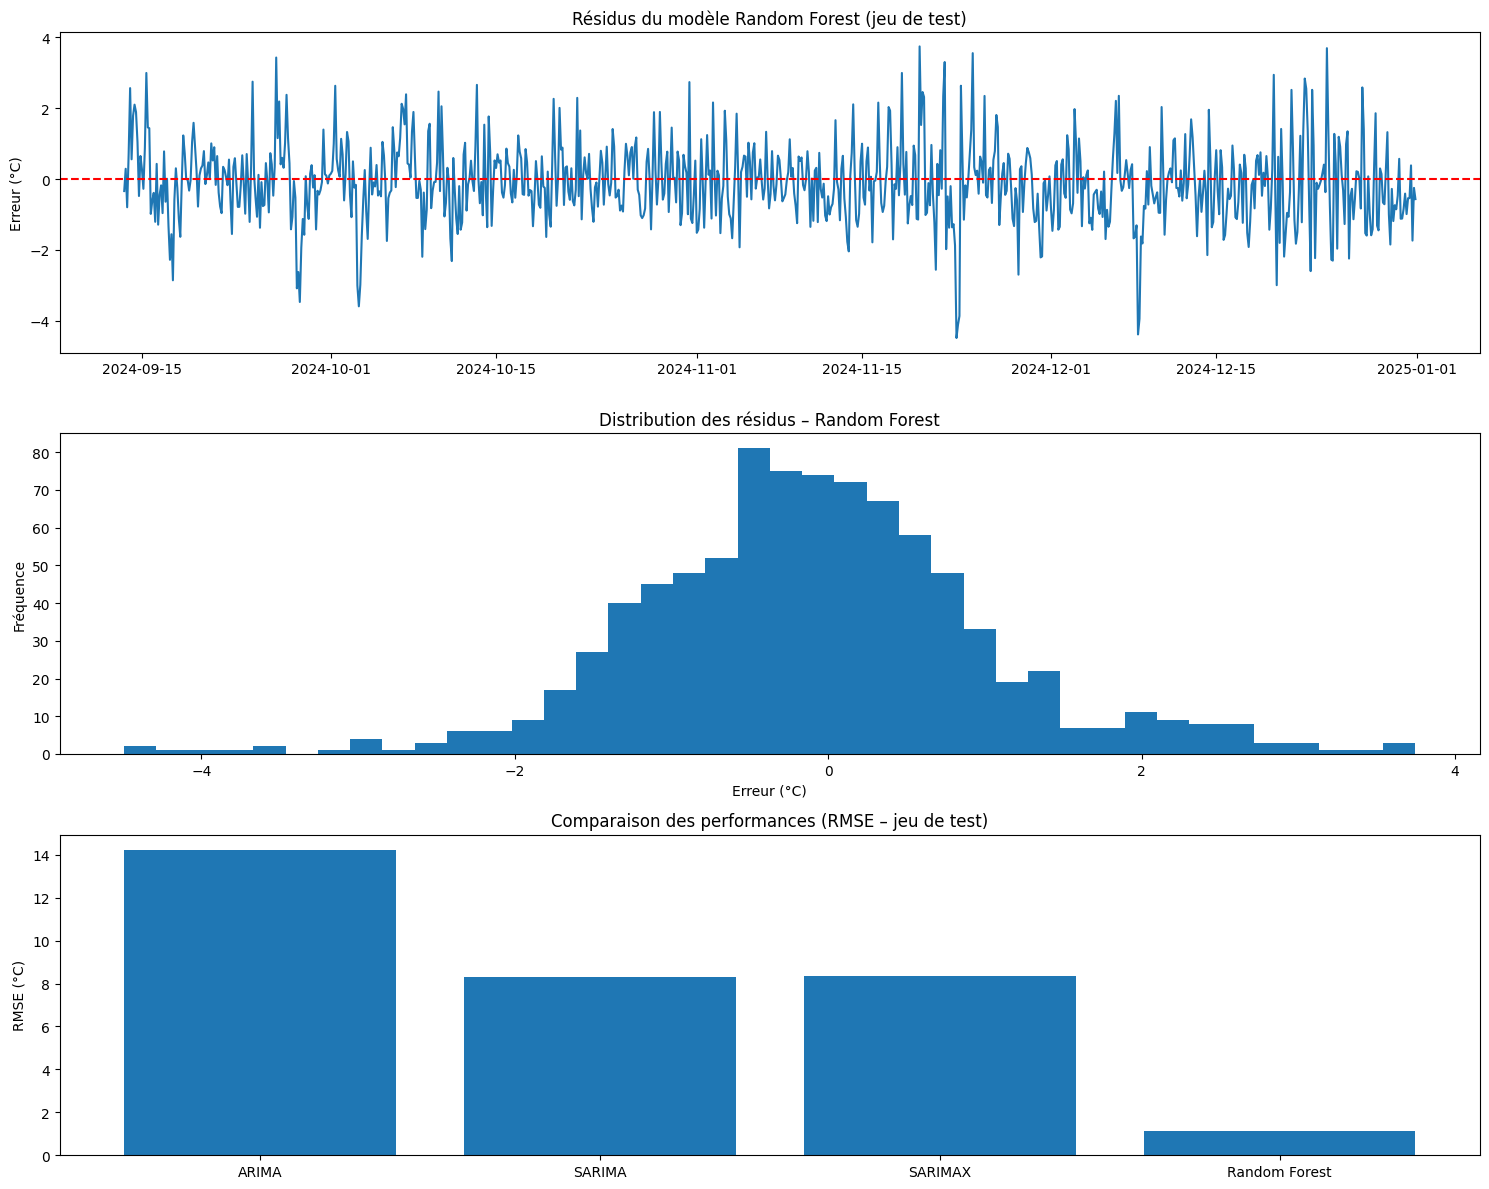

In [57]:
import matplotlib.pyplot as plt
import numpy as np

residuals_rf = pd.Series(
    y_test.values - rf_pred_test,
    index=y_test.index
)

# ======================================================
# FIGURE UNIQUE : RÉSIDUS + COMPARAISON MODÈLES
# ======================================================
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# ------------------------------------------------------
# 1️⃣ Résidus Random Forest dans le temps
# ------------------------------------------------------
axes[0].plot(residuals_rf.index, residuals_rf.values)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_title("Résidus du modèle Random Forest (jeu de test)")
axes[0].set_ylabel("Erreur (°C)")

# ------------------------------------------------------
# 2️⃣ Distribution des résidus
# ------------------------------------------------------
axes[1].hist(residuals_rf.values, bins=40)
axes[1].set_title("Distribution des résidus – Random Forest")
axes[1].set_xlabel("Erreur (°C)")
axes[1].set_ylabel("Fréquence")

# ------------------------------------------------------
# 3️⃣ Comparaison des performances (RMSE test)
# ------------------------------------------------------
models = ["ARIMA", "SARIMA", "SARIMAX", "Random Forest"]
rmse_values = [arima_rmse, sarima_rmse, sarimax_rmse, rmse_test]

axes[2].bar(models, rmse_values)
axes[2].set_title("Comparaison des performances (RMSE – jeu de test)")
axes[2].set_ylabel("RMSE (°C)")

plt.tight_layout()
plt.show()
